In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import argparse
import h5py
from scipy.stats import t as student_t
from statsmodels.stats import multitest as mt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# IDP_df = pd.read_pickle('male_IDP_prototype.pkl')
# vars_df = pd.read_pickle('male_vars_prototype.pkl')

IDP_df = pd.read_pickle('male_IDP_testB.pkl')
vars_df = pd.read_pickle('male_vars_testB.pkl')

with open('IDP_names.txt') as f:
    IDP_names = f.readlines()
    IDP_names = [l.strip('\n\r') for l in IDP_names]
    IDP_names = np.array(IDP_names)
# vars_categories = np.loadtxt("vars_categories.txt", dtype=str, delimiter='\n')
with open('IDP_categories.txt') as f:
    IDP_categories = f.readlines()
    IDP_categories = [l.strip('\n\r') for l in IDP_categories]
    IDP_categories = np.array(IDP_categories)


with open('varsHeader.txt') as f:
    varsHeader = f.readlines()
    varsHeader = [l.strip('\n\r') for l in varsHeader]
    varsHeader = np.array(varsHeader)
# vars_categories = np.loadtxt("vars_categories.txt", dtype=str, delimiter='\n')
with open('vars_categories.txt') as f:
    vars_categories = f.readlines()
    vars_categories = [l.strip('\n\r') for l in vars_categories]
    vars_categories = np.array(vars_categories)

In [3]:
vars_df.head()

,modality,bonf,fdr,dataframe
0,T1_nonlinear,5.443326,4.755399,idx ...
1,T1_linear,5.443326,NaN,idx ...
2,jacobian,5.443326,NaN,idx ...
3,vbm,5.443326,4.996503,idx ...
4,T2_nonlinear,5.443326,5.612791,idx ...


In [4]:
vars_df.iloc[0].dataframe.head()

,idx,names,Categories,pearson_r,t_test_statistic,p_values_corrected,p_values,abs_pearson_r,log_p_values,log_p_values_corrected
0,0,Ethnic background (0.0),Ethnic Background,0.014256,0.664910,1.00000,0.506179,0.014256,0.295696,-0.000000
1,1,Ethnic background (1.0),Ethnic Background,-0.029316,0.578459,1.00000,0.563289,0.029316,0.249269,-0.000000
2,2,Ethnic background (2.0),Ethnic Background,0.060473,1.530274,0.97635,0.126445,0.060473,0.898099,0.010394
3,3,Genotype measurement batch (0.0),Genetic Markers,-0.026032,1.203263,1.00000,0.229008,0.026032,0.640149,-0.000000
4,4,Heterozygosity (0.0),Genetic Markers,-0.010863,0.501956,1.00000,0.615750,0.010863,0.210595,-0.000000


In [5]:
vars_over_bThr_list = []

for idx in range(len(vars_df)):
    df = vars_df.iloc[idx].dataframe
    bThr = vars_df.iloc[idx].bonf
    vars_over_bThr = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_bThr:
        vars_over_bThr_list.append(var)

In [6]:
print("Number of unique vars across all modalities: ", len(set(vars_over_bThr_list)))

Number of unique vars across all modalities:  42


In [7]:
unique_vars_over_bTHr = list(set(vars_over_bThr_list))

In [8]:
unique_vars_over_bThr_categories = []

for var in unique_vars_over_bTHr:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars_over_bThr_categories.append(category)

In [9]:
sorted(unique_vars_over_bTHr)

['Alcohol (2.0)',
 'Alcohol intake frequency. (0.0)',
 'Alcohol intake frequency. (2.0)',
 'Antibiotic codes for last 3 months (1141180228 - amoxicillin product)',
 'Arms BMD (bone mineral density) (2.0)',
 'Cardiac index during PWA (2.0)',
 'Cardiac output during PWA (2.0)',
 'Central augmentation pressure during PWA (2.0)',
 'Central augmentation pressure during PWA (2.1)',
 'Central systolic blood pressure during PWA (2.0)',
 'Cereal intake (2.0)',
 'Diabetes diagnosed by doctor (2.0)',
 'Diagnoses - ICD10 (S761 - S76.1 Injury of quadriceps muscle and tendon)',
 'Diagnoses - ICD10 (W014 - W01.4 Street and highway)',
 'Diagnoses - main ICD10 (S761 - S76.1 Injury of quadriceps muscle and tendon)',
 'Diagnoses - secondary ICD10 (E119 - E11.9 Without complications)',
 'Diagnoses - secondary ICD10 (I10 - I10 Essential (primary) hypertension)',
 'End systolic pressure during PWA (2.0)',
 'End systolic pressure during PWA (2.1)',
 'External causes - ICD10 (W014 - W01.4 Street and highway)'

In [10]:
modalities = []
pearson_rs_list = []
for var in unique_vars_over_bTHr:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df)):
        df = vars_df.iloc[idx].dataframe
        modality = vars_df.iloc[idx].modality
        bThr = vars_df.iloc[idx].bonf
        df = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False)
        vars_over_bThr = df.names.to_list()
        pearson_r_over_bThr = df.pearson_r.to_list()
        if var in vars_over_bThr:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_bThr[vars_over_bThr.index(var)])
    modalities.append(modalities_with_var)
    pearson_rs_list.append(pearsonRs_with_var)

In [11]:
len(modalities)

42

In [12]:
df_vars_over_bThr = pd.DataFrame.from_dict({
    'names': unique_vars_over_bTHr,
    'Categories': unique_vars_over_bThr_categories,
    'modalities': modalities,
    'pearson_r': pearson_rs_list
})

In [13]:
df_vars_over_bThr.head()

,names,Categories,modalities,pearson_r
0,Diagnoses - main ICD10 (S761 - S76.1 Injury of...,Medical History,[tfmri_c_2],[-0.10750207285328192]
1,Operative procedures - OPCS4 (W153 - W15.3 Ost...,Medical History,[tbss_L1_s],[0.10056576037335264]
2,End systolic pressure during PWA (2.0),Cardiac & Circulartory Measurements,[T2_lesions],[0.11833687647324198]
3,Head BMC (bone mineral content) (2.0),Skeletal Measurements,"[rsfmri_0, rsfmri_2, rsfmri_5, rsfmri_8, rsfmr...","[-0.1137457875824289, -0.11737838052287235, -0..."
4,Hand grip strength (left) (2.0),Physical Measurements,[rsfmri_12],[-0.11039600610878327]


In [14]:
set(df_vars_over_bThr.Categories.to_list())

{'Alcohol',
 'Blood Assays',
 'Cardiac & Circulartory Measurements',
 'Diet',
 'Medical History',
 'Physical Measurements',
 'Skeletal Measurements',
 'Tobacco'}

In [15]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        for i, mod in enumerate(mods[0]):
            print('   -> {} ({:.3f})'.format(mod, prs[0][i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> tbss_L1 (0.106)
   -> tbss_L2 (0.106)
   -> tbss_MD (0.107)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> tbss_FA_s (0.108)
   -> tbss_L1_s (0.109)
   -> tbss_OD_s (0.105)
   -> tbss_ICVF (0.105)
   -> tbss_L1 (0.110)
   -> tbss_L2 (0.100)
   -> tbss_MD (0.104)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> tbss_FA_s (0.141)
   -> tbss_L1_s (0.137)
   -> tbss_MO_s (0.126)
   -> tbss_OD_s (0.137)
   -> tbss_L1 (0.133)
   -> tbss_L2 (0.131)
   -> tbss_L3 (0.125)
   -> tbss_MD (0.136)
Var: Frequency of failure to fulfil normal expectations due to drinking alcohol in last year (0.0)
   Modalities:
   -> T1_nonlinear (0.150)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> tbss_ICVF_s (-0.114)
   -> tbss_FA (-0.112)
   -> tbss_ISOVF (-0.108)
   -> tbss_L2 (-0.105)
   -> tbss_OD (

In [16]:
sorted(prs[0], reverse=True)

[0.11071845837274379,
 0.10809776335096122,
 0.10408317300819483,
 0.10235651656708525,
 0.10085781077025761,
 0.09912160868563288]

In [17]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        for i, mod in enumerate(mods):
            print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> tbss_MD (0.107)
   -> tbss_L2 (0.106)
   -> tbss_L1 (0.106)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> tbss_L1 (0.110)
   -> tbss_L1_s (0.109)
   -> tbss_FA_s (0.108)
   -> tbss_OD_s (0.105)
   -> tbss_ICVF (0.105)
   -> tbss_MD (0.104)
   -> tbss_L2 (0.100)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> tbss_FA_s (0.141)
   -> tbss_L1_s (0.137)
   -> tbss_OD_s (0.137)
   -> tbss_MD (0.136)
   -> tbss_L1 (0.133)
   -> tbss_L2 (0.131)
   -> tbss_MO_s (0.126)
   -> tbss_L3 (0.125)
Var: Frequency of failure to fulfil normal expectations due to drinking alcohol in last year (0.0)
   Modalities:
   -> T1_nonlinear (0.150)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> tbss_OD (-0.118)
   -> tbss_ICVF_s (-0.114)
   -> tbss_FA (-0.112)
   -> tbss_ISOVF (-0.108)
   -> tbss_L2 (

In [18]:
variance_threshold = 0.1

for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        if abs(prs[0]) >= variance_threshold:
            print('Var: {}'.format(name))
            print('   Modalities:')
            for i, mod in enumerate(mods):
                if abs(prs[i]) >= variance_threshold:
                    print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> tbss_MD (0.107)
   -> tbss_L2 (0.106)
   -> tbss_L1 (0.106)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> tbss_L1 (0.110)
   -> tbss_L1_s (0.109)
   -> tbss_FA_s (0.108)
   -> tbss_OD_s (0.105)
   -> tbss_ICVF (0.105)
   -> tbss_MD (0.104)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> tbss_FA_s (0.141)
   -> tbss_L1_s (0.137)
   -> tbss_OD_s (0.137)
   -> tbss_MD (0.136)
   -> tbss_L1 (0.133)
   -> tbss_L2 (0.131)
   -> tbss_MO_s (0.126)
   -> tbss_L3 (0.125)
Var: Frequency of failure to fulfil normal expectations due to drinking alcohol in last year (0.0)
   Modalities:
   -> T1_nonlinear (0.150)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> tbss_OD (-0.118)
   -> tbss_ICVF_s (-0.114)
   -> tbss_FA (-0.112)
   -> tbss_ISOVF (-0.108)
   -> tbss_L2 (-0.105)


Category: Ca

In [19]:
variance_threshold = 0.1

for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        if abs(prs[0]) >= variance_threshold:
            print('Var: {}'.format(name))
            print('   Modalities:')
#             for i, mod in enumerate(mods):
#                 if abs(prs[0]) >= variance_threshold:
            print('   -> {} ({:.3f})'.format(mods[0], prs[0]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> tbss_MD (0.107)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> tbss_L1 (0.110)
Var: Frequency of drinking alcohol (0.0)
   Modalities:
   -> tbss_FA_s (0.141)
Var: Frequency of failure to fulfil normal expectations due to drinking alcohol in last year (0.0)
   Modalities:
   -> T1_nonlinear (0.150)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)
   Modalities:
   -> tbss_OD (-0.118)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Cardiac index during PWA (2.0)
   Modalities:
   -> tbss_ICVF_s (0.113)
Var: Cardiac output during PWA (2.0)
   Modalities:
   -> tbss_ICVF_s (0.110)
Var: Central augmentation pressure during PWA (2.0)
   Modalities:
   -> tbss_ISOVF (0.106)
Var: Central augmentation pressure during PWA (2.1)
   Modalities:
   -> tbss_ISOVF (0.108)

In [20]:
mods

('tbss_ISOVF', 'tbss_L2_s', 'tbss_L2', 'tbss_ISOVF_s', 'tbss_L1', 'vbm')

In [21]:
counter = 0
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()[0]
        print('Var: {}'.format(name))
        counter += 1
    print('\n')
    
print("There are {} vars in total".format(counter))

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
Var: Alcohol intake frequency. (2.0)
Var: Frequency of drinking alcohol (0.0)
Var: Frequency of failure to fulfil normal expectations due to drinking alcohol in last year (0.0)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Cardiac index during PWA (2.0)
Var: Cardiac output during PWA (2.0)
Var: Central augmentation pressure during PWA (2.0)
Var: Central augmentation pressure during PWA (2.1)
Var: Central systolic blood pressure during PWA (2.0)
Var: End systolic pressure during PWA (2.0)
Var: End systolic pressure during PWA (2.1)
Var: Mean arterial pressure during PWA (2.0)
Var: Mean arterial pressure during PWA (2.1)
Var: Systolic blood pressure, automated reading (0.1)
Var: Systolic brachial blood pressure (2.0)


Category: Diet
-------

In [22]:
counter = 0
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()[0]
        if 'T1_linear' in mods or 'T1_nonlinear' in mods or 'T2_nonlinear' in mods:
            print('Var: {}'.format(name))
            counter += 1
        else:
            pass
    print('\n')
    
print("There are {} vars from the conventional modalities".format(counter))

Category: Alcohol
------------------------------------------------
Var: Frequency of failure to fulfil normal expectations due to drinking alcohol in last year (0.0)


Category: Blood Assays
------------------------------------------------


Category: Cardiac & Circulartory Measurements
------------------------------------------------


Category: Diet
------------------------------------------------


Category: Medical History
------------------------------------------------
Var: External causes - ICD10 (W014 - W01.4 Street and highway)


Category: Physical Measurements
------------------------------------------------


Category: Skeletal Measurements
------------------------------------------------


Category: Tobacco
------------------------------------------------


There are 2 vars from the conventional modalities


In [23]:
counter = 0
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()[0]
        if 'T1_linear' in mods or 'T1_nonlinear' in mods or 'T2_nonlinear' in mods:
            pass
        else:
            print('Var: {}'.format(name))
            counter += 1
    print('\n')
    
print("There are {} vars indepdent from the conventional modalities".format(counter))

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
Var: Alcohol intake frequency. (2.0)
Var: Frequency of drinking alcohol (0.0)


Category: Blood Assays
------------------------------------------------
Var: IGF-1 (0.0)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Cardiac index during PWA (2.0)
Var: Cardiac output during PWA (2.0)
Var: Central augmentation pressure during PWA (2.0)
Var: Central augmentation pressure during PWA (2.1)
Var: Central systolic blood pressure during PWA (2.0)
Var: End systolic pressure during PWA (2.0)
Var: End systolic pressure during PWA (2.1)
Var: Mean arterial pressure during PWA (2.0)
Var: Mean arterial pressure during PWA (2.1)
Var: Systolic blood pressure, automated reading (0.1)
Var: Systolic brachial blood pressure (2.0)


Category: Diet
------------------------------------------------
Var: Alcohol (2.0)
Var: Cereal intake (2.0)
Var: Leek int

In [24]:
len(vars_categories)

17527

In [25]:
len(set(vars_categories))

19

In [26]:
unique_vars_categories = list(set(vars_categories))

In [27]:
unique_vars_counters = []
for unique_category in unique_vars_categories:
    counter = 0
    for category in vars_categories:
        if unique_category == category:
            counter += 1
    unique_vars_counters.append(counter)

In [28]:
unique_vars_counters

[1689,
 107,
 63,
 434,
 9780,
 468,
 755,
 1167,
 32,
 138,
 815,
 333,
 3,
 297,
 122,
 260,
 868,
 16,
 180]

In [29]:
df_vars_over_bThr.head()

,names,Categories,modalities,pearson_r
0,Diagnoses - main ICD10 (S761 - S76.1 Injury of...,Medical History,[tfmri_c_2],[-0.10750207285328192]
1,Operative procedures - OPCS4 (W153 - W15.3 Ost...,Medical History,[tbss_L1_s],[0.10056576037335264]
2,End systolic pressure during PWA (2.0),Cardiac & Circulartory Measurements,[T2_lesions],[0.11833687647324198]
3,Head BMC (bone mineral content) (2.0),Skeletal Measurements,"[rsfmri_0, rsfmri_2, rsfmri_5, rsfmri_8, rsfmr...","[-0.1137457875824289, -0.11737838052287235, -0..."
4,Hand grip strength (left) (2.0),Physical Measurements,[rsfmri_12],[-0.11039600610878327]


In [30]:
vars_df.head()

,modality,bonf,fdr,dataframe
0,T1_nonlinear,5.443326,4.755399,idx ...
1,T1_linear,5.443326,NaN,idx ...
2,jacobian,5.443326,NaN,idx ...
3,vbm,5.443326,4.996503,idx ...
4,T2_nonlinear,5.443326,5.612791,idx ...


In [31]:
vars_df.iloc[0].dataframe

,idx,names,Categories,pearson_r,t_test_statistic,p_values_corrected,p_values,abs_pearson_r,log_p_values,log_p_values_corrected
0,0,Ethnic background (0.0),Ethnic Background,0.014256,0.664910,1.000000,0.506179,0.014256,0.295696,-0.000000
1,1,Ethnic background (1.0),Ethnic Background,-0.029316,0.578459,1.000000,0.563289,0.029316,0.249269,-0.000000
2,2,Ethnic background (2.0),Ethnic Background,0.060473,1.530274,0.976350,0.126445,0.060473,0.898099,0.010394
3,3,Genotype measurement batch (0.0),Genetic Markers,-0.026032,1.203263,1.000000,0.229008,0.026032,0.640149,-0.000000
4,4,Heterozygosity (0.0),Genetic Markers,-0.010863,0.501956,1.000000,0.615750,0.010863,0.210595,-0.000000
...,...,...,...,...,...,...,...,...,...,...
13872,17504,Substances taken for depression (0.1),Mental Health,0.098974,1.798598,0.887889,0.073004,0.098974,1.136651,0.051641
13873,17506,Activities undertaken to treat depression (0.1),Mental Health,-0.099825,1.598931,0.949901,0.111079,0.099825,0.954368,0.022322
13874,17507,Manifestations of mania or irritability (0.1),Mental Health,-0.047695,0.791841,1.000000,0.429136,0.047695,0.367405,-0.000000
13875,17525,Ever been offered/sought treatment for anxiety...,Mental Health,-0.029614,1.205283,1.000000,0.228266,0.029614,0.641558,-0.000000


In [32]:
categories_of_interest = list(set(df_vars_over_bThr.Categories.to_list()))
categories_of_interest.sort()

In [33]:
categories_of_interest

['Alcohol',
 'Blood Assays',
 'Cardiac & Circulartory Measurements',
 'Diet',
 'Medical History',
 'Physical Measurements',
 'Skeletal Measurements',
 'Tobacco']

In [34]:
df_of_interest = vars_df.iloc[0].dataframe
bThr = vars_df.iloc[0].bonf
print(bThr)
len(df_of_interest[(df_of_interest.Categories=='Alcohol') & (df_of_interest.log_p_values>=bThr)])

5.443325583953745


1

In [35]:
modalities = []
counters = []


for idx in range(len(vars_df.modality)):
    
    modality = vars_df.iloc[idx].modality

    df_of_interest = vars_df.iloc[idx].dataframe
    bThr = vars_df.iloc[idx].bonf

    counter = []

    for category in categories_of_interest:
        counter.append(len(df_of_interest[(df_of_interest.Categories==category) & (df_of_interest.log_p_values>=bThr)]))
    
    modalities.append(modality)
    counters.append(counter)


In [36]:
print(np.array(counters)[:,0])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 2 0 0 0 1 2 0 1 0 3 3 1 3 0 0]


In [37]:
# unique_vars_categories
# unique_vars_counters
# categories_of_interest
counters_of_interest = []
for cat in categories_of_interest:
    idx = unique_vars_categories.index(cat)
    counters_of_interest.append(unique_vars_counters[idx])
    
print(counters_of_interest)

for idx, cat in enumerate(unique_vars_categories):
    print(cat, unique_vars_counters[idx])

[138, 468, 815, 1689, 9780, 260, 180, 122]
Diet 1689
Physical Activity 107
Genetic Markers 63
Eye Test 434
Medical History 9780
Blood Assays 468
Hearing Test 755
Cognitive Tests 1167
Early Life Factors 32
Alcohol 138
Cardiac & Circulartory Measurements 815
Physical Test 333
Ethnic Background 3
Mental Health 297
Tobacco 122
Physical Measurements 260
Lifestyle 868
Data Collection Duration 16
Skeletal Measurements 180


In [38]:
unique_vars_categories2, unique_vars_counters2 = zip(*sorted(zip(unique_vars_categories, unique_vars_counters)))

In [39]:
for idx, cat in enumerate(unique_vars_categories2):
    print(cat, '(' +  str(unique_vars_counters2[idx]) + ')')

Alcohol (138)
Blood Assays (468)
Cardiac & Circulartory Measurements (815)
Cognitive Tests (1167)
Data Collection Duration (16)
Diet (1689)
Early Life Factors (32)
Ethnic Background (3)
Eye Test (434)
Genetic Markers (63)
Hearing Test (755)
Lifestyle (868)
Medical History (9780)
Mental Health (297)
Physical Activity (107)
Physical Measurements (260)
Physical Test (333)
Skeletal Measurements (180)
Tobacco (122)


In [40]:
# counters = np.array(counters)
# dct = {}
# dct['modality'] = modalities
# for idx, cat in enumerate(categories_of_interest):
#     dct[cat] = counters[:, idx]
    
# df_dct = pd.DataFrame.from_dict(dct)
# df_dct

In [41]:
counters = np.array(counters)
dct = {}
dct['modality'] = modalities
for idx, cat in enumerate(categories_of_interest):
    dct[cat] = counters[:, idx] / counters_of_interest[idx]
    
df_dct = pd.DataFrame.from_dict(dct)
df_dct.replace([np.inf, -np.inf], np.nan, inplace=True)
df_dct

,modality,Alcohol,Blood Assays,Cardiac & Circulartory Measurements,Diet,Medical History,Physical Measurements,Skeletal Measurements,Tobacco
0,T1_nonlinear,0.007246,0.000000,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000
1,T1_linear,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,jacobian,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,vbm,0.000000,0.000000,0.000000,0.000000,0.000204,0.000000,0.000000,0.008197
4,T2_nonlinear,0.000000,0.000000,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000
5,T2_lesions,0.000000,0.000000,0.008589,0.000000,0.000000,0.000000,0.000000,0.000000
6,swi,0.000000,0.000000,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000
7,rsfmri_0,0.000000,0.000000,0.000000,0.000592,0.000000,0.000000,0.033333,0.000000
8,rsfmri_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,rsfmri_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038889,0.000000


In [42]:
# counters = np.array(counters)
# dct = {}
# dct['modality'] = modalities
# for idx, cat in enumerate(categories_of_interest):
#     dct[cat] = -np.log10(counters[:, idx] / counters_of_interest[idx])
    
# df_dct = pd.DataFrame.from_dict(dct)
# df_dct.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_dct

In [43]:
df_dct = pd.melt(df_dct, id_vars="modality", var_name="var_name", value_name="var_hits")

In [44]:
df_dct

,modality,var_name,var_hits
0,T1_nonlinear,Alcohol,0.007246
1,T1_linear,Alcohol,0.000000
2,jacobian,Alcohol,0.000000
3,vbm,Alcohol,0.000000
4,T2_nonlinear,Alcohol,0.000000
...,...,...,...
451,tbss_L2,Tobacco,0.008197
452,tbss_L3,Tobacco,0.000000
453,tbss_MD,Tobacco,0.000000
454,tbss_MO,Tobacco,0.000000


/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Alcohol'),
  Text(1, 0, 'Blood Assays'),
  Text(2, 0, 'Cardiac & Circulartory Measurements'),
  Text(3, 0, 'Diet'),
  Text(4, 0, 'Medical History'),
  Text(5, 0, 'Physical Measurements'),
  Text(6, 0, 'Skeletal Measurements'),
  Text(7, 0, 'Tobacco')])

<Figure size 1152x691.2 with 0 Axes>

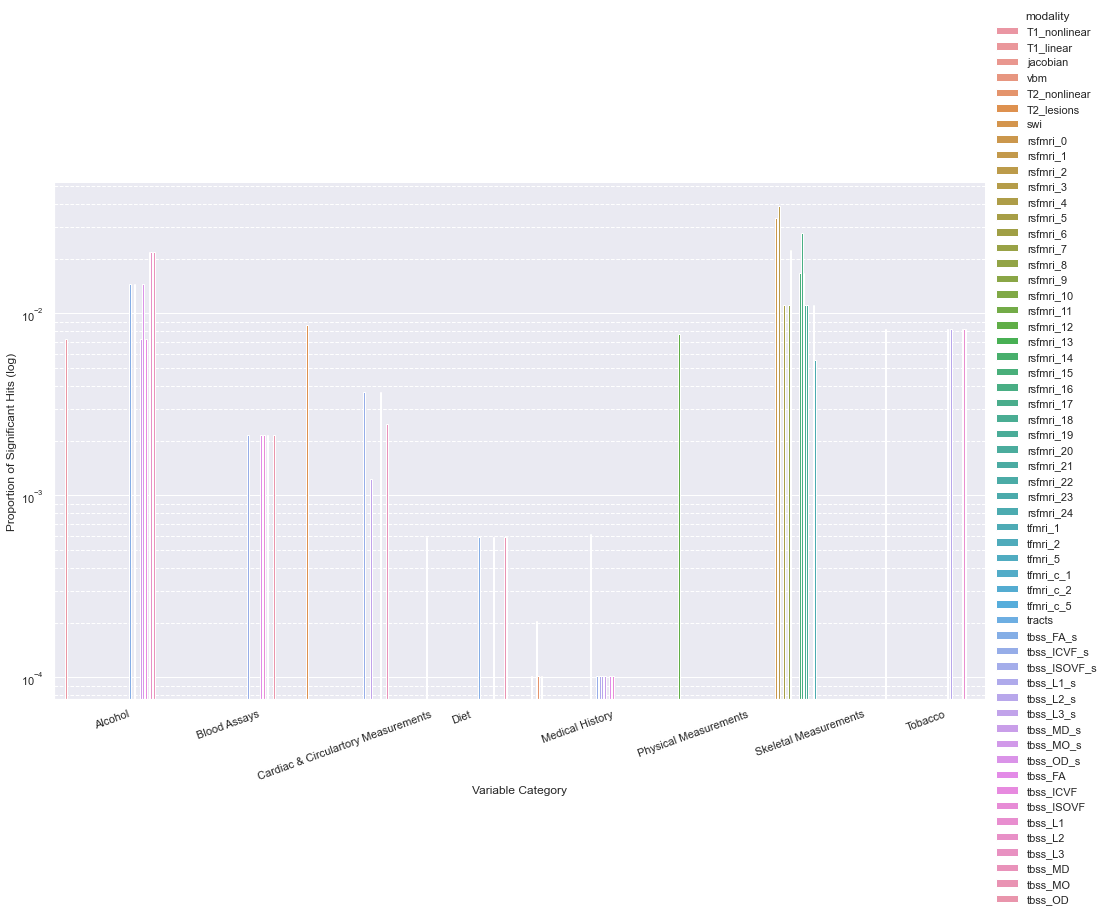

In [45]:
plt.figure(figsize=(16, 9.6))
sns.factorplot(x='var_name', y='var_hits', hue='modality', data=df_dct, kind='bar', height=8, aspect=1.75, log=True)
plt.xlabel('Variable Category')
plt.ylabel('Proportion of Significant Hits (log)')
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=20)
# plt.vlines(x=[1,2,3], ymin=0, ymax=1, color='red')

In [46]:
df_dct

,modality,var_name,var_hits
0,T1_nonlinear,Alcohol,0.007246
1,T1_linear,Alcohol,0.000000
2,jacobian,Alcohol,0.000000
3,vbm,Alcohol,0.000000
4,T2_nonlinear,Alcohol,0.000000
...,...,...,...
451,tbss_L2,Tobacco,0.008197
452,tbss_L3,Tobacco,0.000000
453,tbss_MD,Tobacco,0.000000
454,tbss_MO,Tobacco,0.000000


In [47]:
current_mods = vars_df.modality.values
modality_names = [
    'T1 Nonlinear', 'T1 Linear', 'Jacobian', 'VBM', 'T2 Nonlinear', 'T2 Lessions', 'SWI', 'rsfMRI-0', 'rsfMRI-1',
    'rsfMRI-2', 'rsfMRI-3', 'rsfMRI-4', 'rsfMRI-5', 'rsfMRI-6', 'rsfMRI-7', 'rsfMRI-8', 'rsfMRI-9', 'rsfMRI-10', 
    'rsfMRI-11', 'rsfMRI-12', 'rsfMRI-13', 'rsfMRI-14', 'rsfMRI-15', 'rsfMRI-16', 'rsfMRI-17', 'rsfMRI-18', 'rsfMRI-19',
    'rsfMRI-20', 'rsfMRI-21', 'rsfMRI-22', 'rsfMRI-23', 'rsfMRI-24', 'tfMRI-1', 'tfMRI-2', 'tfMRI-5', 'tfMRI-COPE-1',
    'tfMRI-COPE-2', 'tfMRI-COPE-5', 'Summed Tracts', 'TBSS FA', 'TBSS ICVF', 'TBSS ISOVF', 'TBSS L1', 'TBSS L2',
    'TBSS L3', 'TBSS MD', 'TBSS MO', 'TBSS OD', 'FA', 'ICVF', 'ISOVF', 'L1', 'L2', 'L3', 'MD', 'MO', 'OD'
]
for idx, mod in enumerate(current_mods):
    df_dct.loc[df_dct["modality"] == mod, "modality"] = modality_names[idx]

In [48]:
df_dct

,modality,var_name,var_hits
0,T1 Nonlinear,Alcohol,0.007246
1,T1 Linear,Alcohol,0.000000
2,Jacobian,Alcohol,0.000000
3,VBM,Alcohol,0.000000
4,T2 Nonlinear,Alcohol,0.000000
...,...,...,...
451,L2,Tobacco,0.008197
452,L3,Tobacco,0.000000
453,MD,Tobacco,0.000000
454,MO,Tobacco,0.000000


/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/ipykernel_2717/975455495.py:34: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 0.05])
/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/

<Figure size 1152x691.2 with 0 Axes>

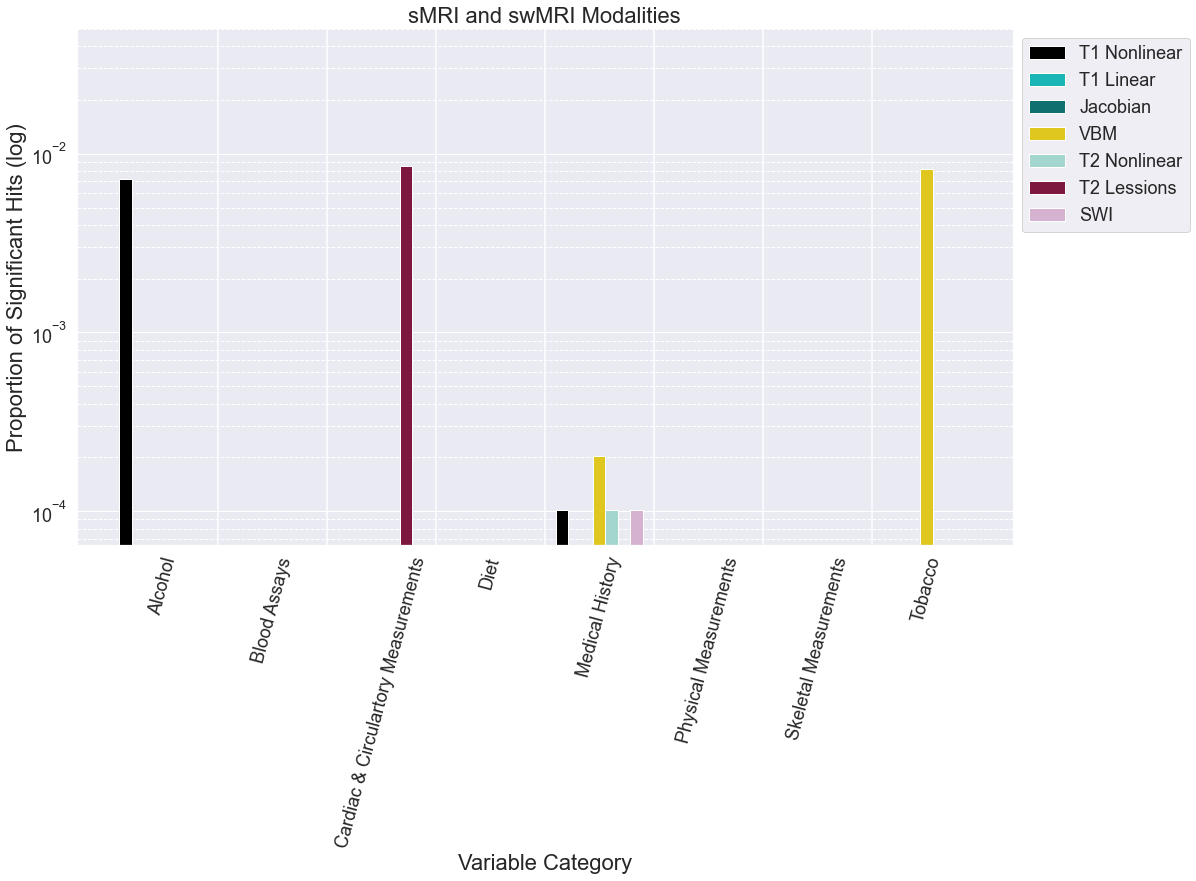

<Figure size 1152x691.2 with 0 Axes>

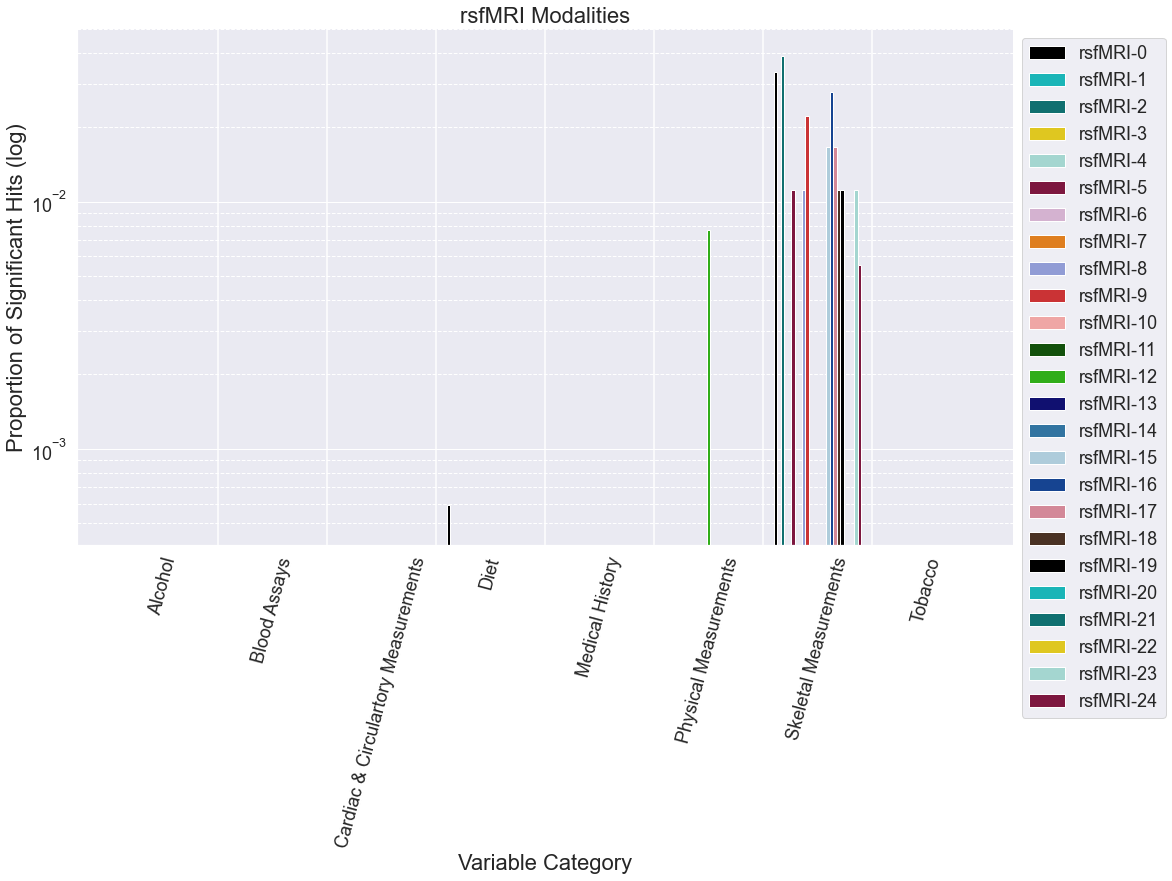

<Figure size 1152x691.2 with 0 Axes>

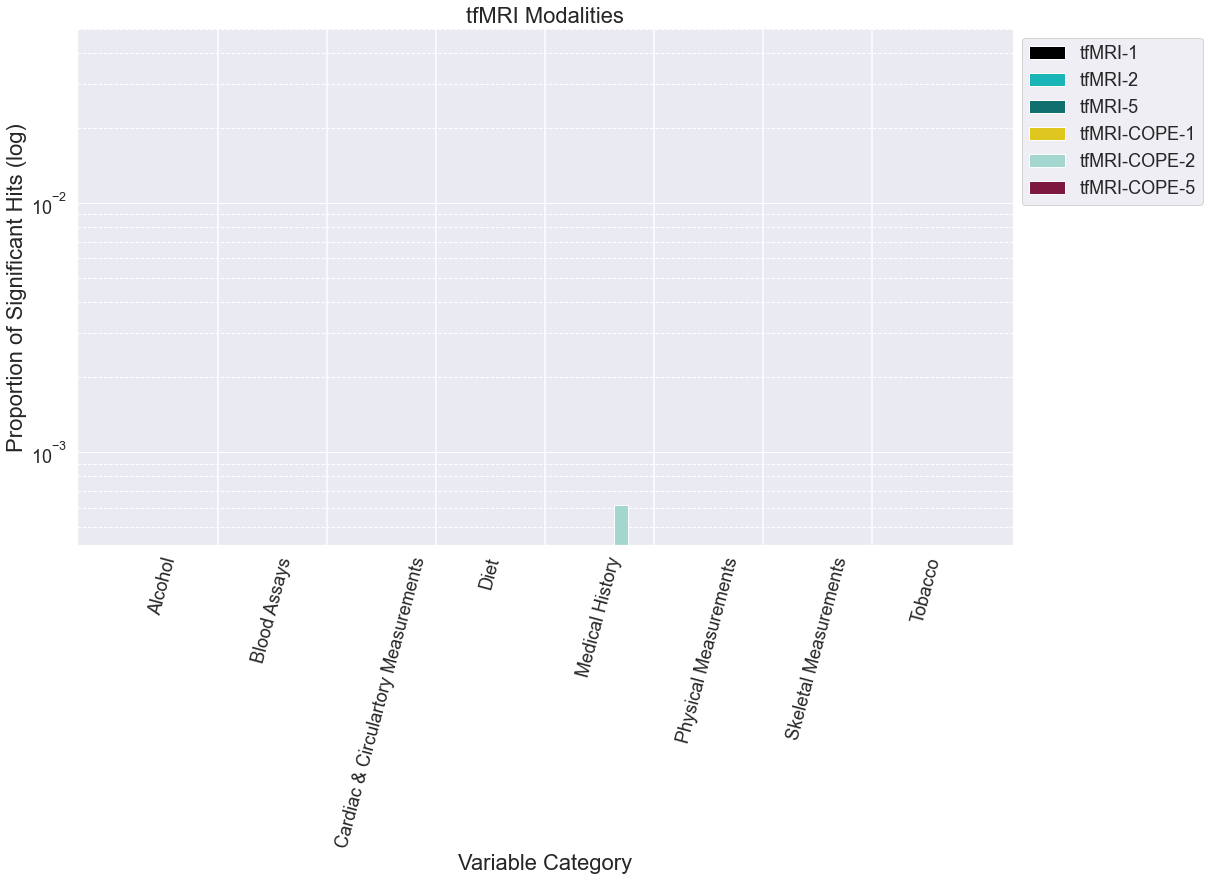

<Figure size 1152x691.2 with 0 Axes>

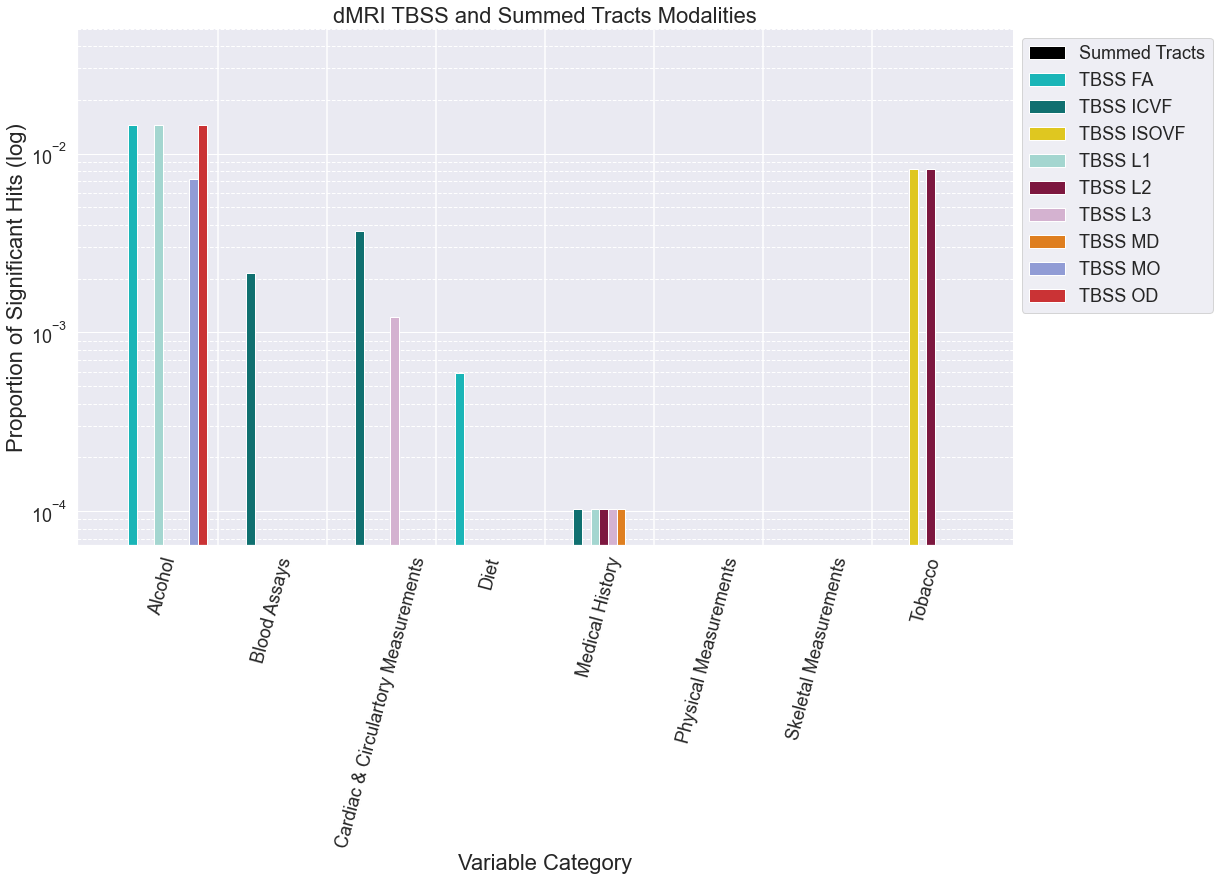

<Figure size 1152x691.2 with 0 Axes>

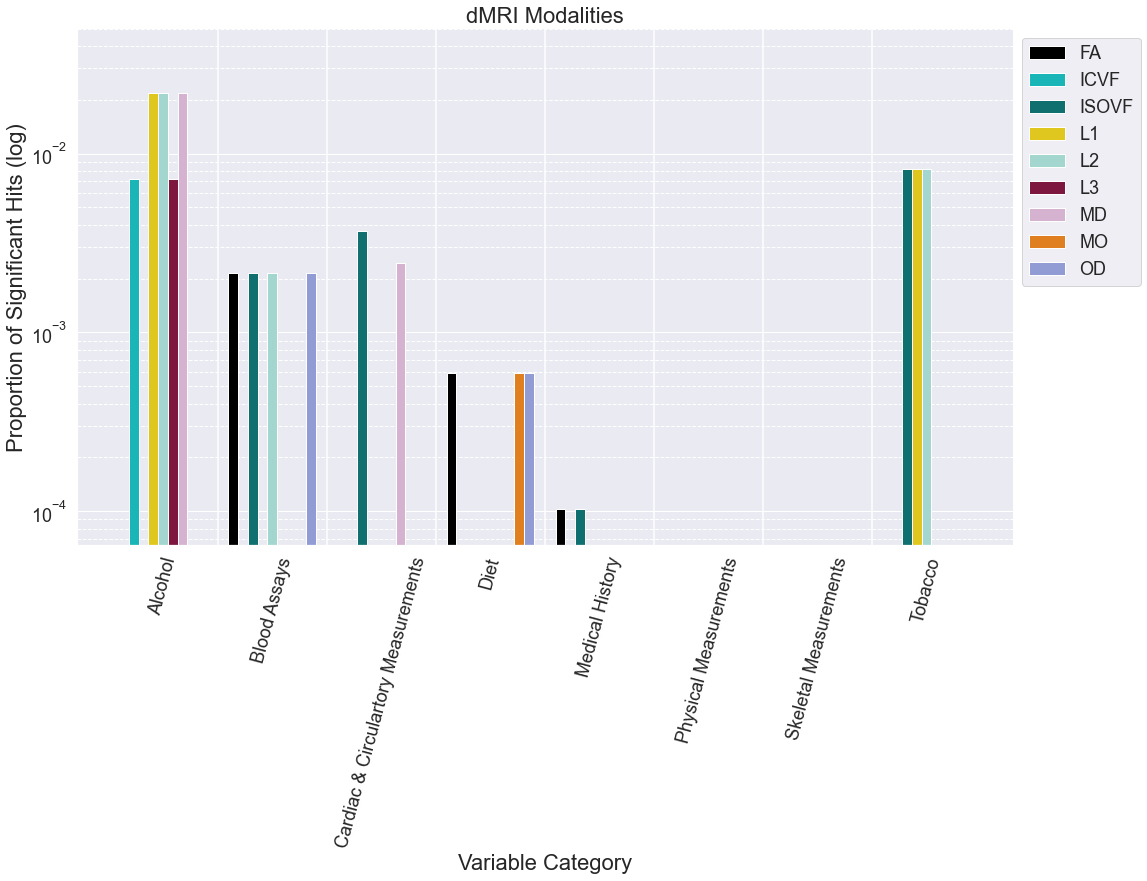

In [49]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'T1 Nonlinear') |
                           (df_dct.modality == 'T1 Linear') |
                           (df_dct.modality == 'Jacobian') |
                           (df_dct.modality == 'VBM') |
                           (df_dct.modality == 'T2 Nonlinear') |
                           (df_dct.modality == 'T2 Lessions') |
                           (df_dct.modality == 'SWI')
                          
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('sMRI and swMRI Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_proportion_significant_hits_sMRI and swMRI Modalities'+'.png', bbox_inches='tight', facecolor='white')


title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'rsfMRI-0') |
                           (df_dct.modality == 'rsfMRI-1') |
                           (df_dct.modality == 'rsfMRI-2') |
                           (df_dct.modality == 'rsfMRI-3') |
                           (df_dct.modality == 'rsfMRI-4') |
                           (df_dct.modality == 'rsfMRI-5') |
                           (df_dct.modality == 'rsfMRI-6') |
                           (df_dct.modality == 'rsfMRI-7') |
                           (df_dct.modality == 'rsfMRI-8') |
                           (df_dct.modality == 'rsfMRI-9') |
                           (df_dct.modality == 'rsfMRI-10') |
                           (df_dct.modality == 'rsfMRI-11') |
                           (df_dct.modality == 'rsfMRI-12') |
                           (df_dct.modality == 'rsfMRI-13') |
                           (df_dct.modality == 'rsfMRI-14') |
                           (df_dct.modality == 'rsfMRI-15') |
                           (df_dct.modality == 'rsfMRI-16') |
                           (df_dct.modality == 'rsfMRI-17') |
                           (df_dct.modality == 'rsfMRI-18') |
                           (df_dct.modality == 'rsfMRI-19') |
                           (df_dct.modality == 'rsfMRI-20') |
                           (df_dct.modality == 'rsfMRI-21') |
                           (df_dct.modality == 'rsfMRI-22') |
                           (df_dct.modality == 'rsfMRI-23') |
                           (df_dct.modality == 'rsfMRI-24')         
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('rsfMRI Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_proportion_significant_hits_rsfMRI Modalities'+'.png', bbox_inches='tight', facecolor='white')




title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'tfMRI-1') |
                           (df_dct.modality == 'tfMRI-2') |
                           (df_dct.modality == 'tfMRI-5') |
                           (df_dct.modality == 'tfMRI-COPE-1') |
                           (df_dct.modality == 'tfMRI-COPE-2') |
                           (df_dct.modality == 'tfMRI-COPE-5') 
                           
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('tfMRI Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_proportion_significant_hits_tfMRI Modalities'+'.png', bbox_inches='tight', facecolor='white')




title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'Summed Tracts') |
                           (df_dct.modality == 'TBSS FA') |
                           (df_dct.modality == 'TBSS ICVF') |
                           (df_dct.modality == 'TBSS ISOVF') |
                           (df_dct.modality == 'TBSS L1') |
                           (df_dct.modality == 'TBSS L2') |
                           (df_dct.modality == 'TBSS L3') | 
                           (df_dct.modality == 'TBSS MD') |
                           (df_dct.modality == 'TBSS MO') |
                           (df_dct.modality == 'TBSS OD') 

                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('dMRI TBSS and Summed Tracts Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_proportion_significant_hits_dMRI TBSS and Summed Tracts Modalities'+'.png', bbox_inches='tight', facecolor='white')




title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[
                           (df_dct.modality == 'FA') |
                           (df_dct.modality == 'ICVF') |
                           (df_dct.modality == 'ISOVF') |
                           (df_dct.modality == 'L1') |
                           (df_dct.modality == 'L2') |
                           (df_dct.modality == 'L3') | 
                           (df_dct.modality == 'MD') |
                           (df_dct.modality == 'MO') |
                           (df_dct.modality == 'OD') 

                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('dMRI Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_proportion_significant_hits_dMRI Modalities'+'.png', bbox_inches='tight', facecolor='white')

/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/ipykernel_2717/2017978572.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 0.4])


<Figure size 1152x691.2 with 0 Axes>

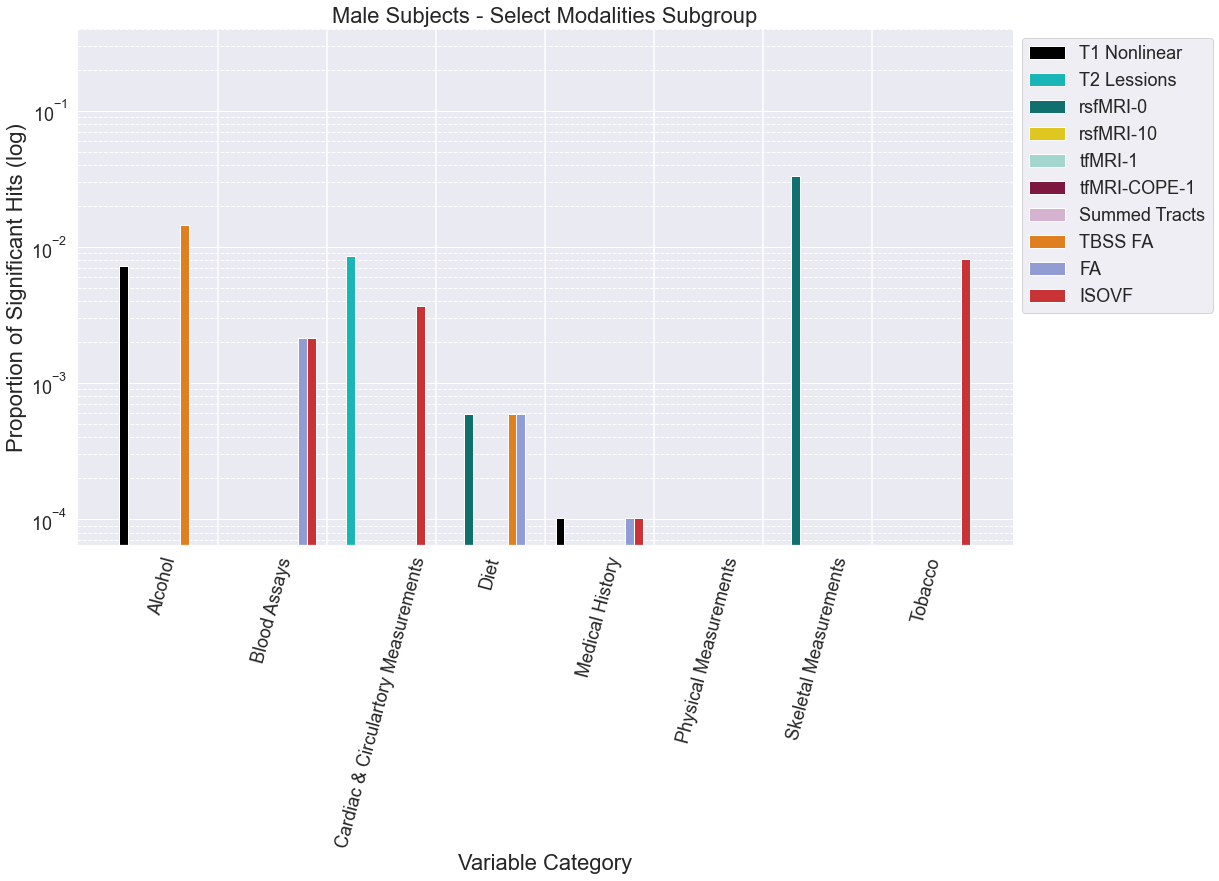

In [51]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

# T1 NonLinear, T2 Lessions, rsfmri-0, rsfmri-10, tfmri-1, tfmri1-cope, Summed Tracts, FA, TBSS FA, 

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'T1 Nonlinear') |
                           (df_dct.modality == 'T2 Lessions') |
                           (df_dct.modality == 'rsfMRI-0') |
                           (df_dct.modality == 'rsfMRI-10') |
                           (df_dct.modality == 'tfMRI-1') |
                           (df_dct.modality == 'tfMRI-COPE-1') |
                           (df_dct.modality == 'Summed Tracts') |
                           (df_dct.modality == 'FA') |
                           (df_dct.modality == 'TBSS FA') |
                           (df_dct.modality == 'ISOVF')
                          
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('Male Subjects - Select Modalities Subgroup', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.4])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')

plt.savefig('Male_proportion_significant_hits_SelectModalities.png', bbox_inches='tight', facecolor='white')


In [52]:
vars_over_FDR_list = []

for idx in range(len(vars_df)):
    df = vars_df.iloc[idx].dataframe
    FDR = vars_df.iloc[idx].fdr
    vars_over_FDR = df[df.log_p_values>=FDR].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_FDR:
        vars_over_FDR_list.append(var)
        
print("Number of unique vars across all modalities: ", len(set(vars_over_FDR_list)))

unique_vars_over_FDR = list(set(vars_over_FDR_list))

unique_vars_over_FDR_categories = []

for var in unique_vars_over_FDR:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars_over_FDR_categories.append(category)
    
modalities = []
pearson_rs_list = []
for var in unique_vars_over_FDR:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df)):
        df = vars_df.iloc[idx].dataframe
        modality = vars_df.iloc[idx].modality
        FDR = vars_df.iloc[idx].bonf
        df = df[df.log_p_values>=FDR].sort_values('log_p_values', ascending=False)
        vars_over_FDR = df.names.to_list()
        pearson_r_over_FDR = df.pearson_r.to_list()
        if var in vars_over_FDR:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_FDR[vars_over_FDR.index(var)])
    modalities.append(modalities_with_var)
    pearson_rs_list.append(pearsonRs_with_var)
    
print(len(modalities))

df_vars_over_FDR = pd.DataFrame.from_dict({
    'names': unique_vars_over_FDR,
    'Categories': unique_vars_over_FDR_categories,
    'modalities': modalities,
    'pearson_r': pearson_rs_list
})

Number of unique vars across all modalities:  91
91


/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/ipykernel_96738/1047109375.py:34: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 0.4])
/Users/andreiroibu/opt/anaconda3/envs/agemapper2/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn

<Figure size 1152x691.2 with 0 Axes>

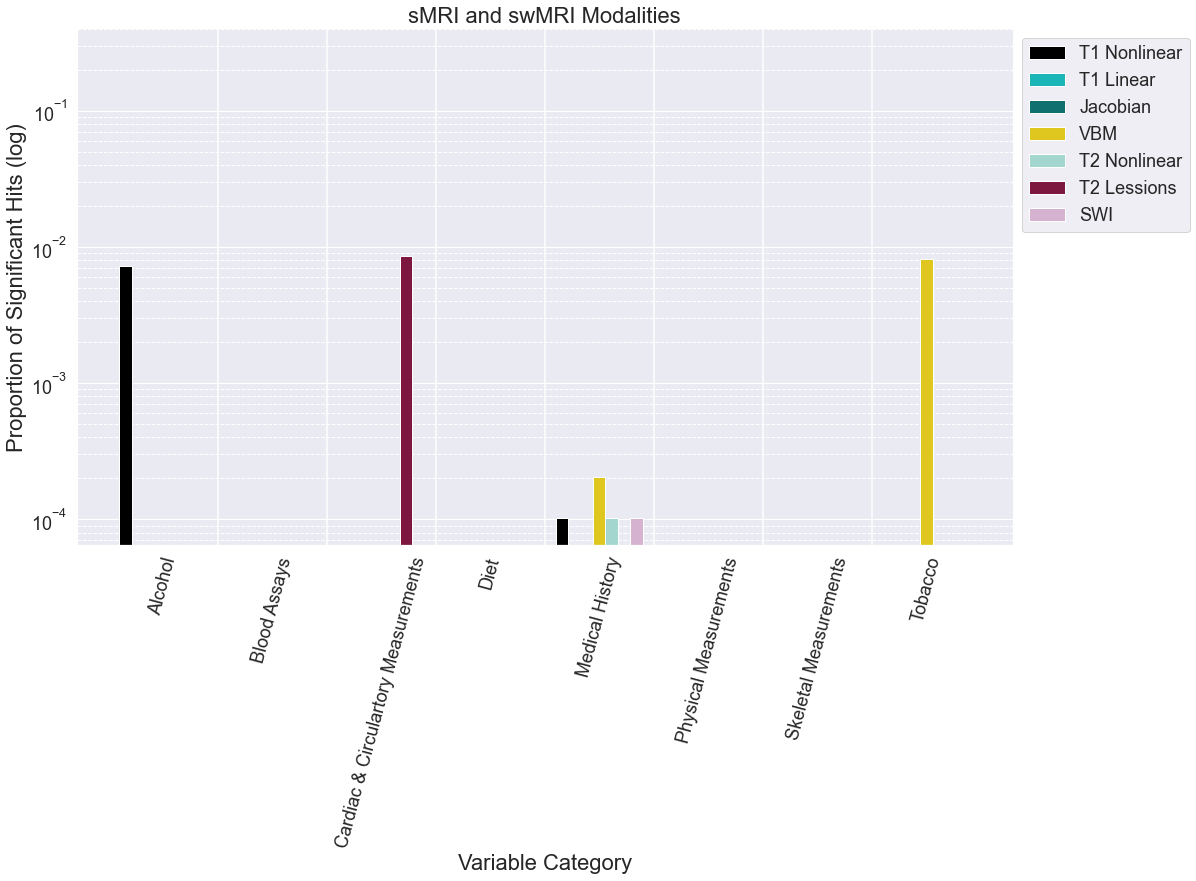

<Figure size 1152x691.2 with 0 Axes>

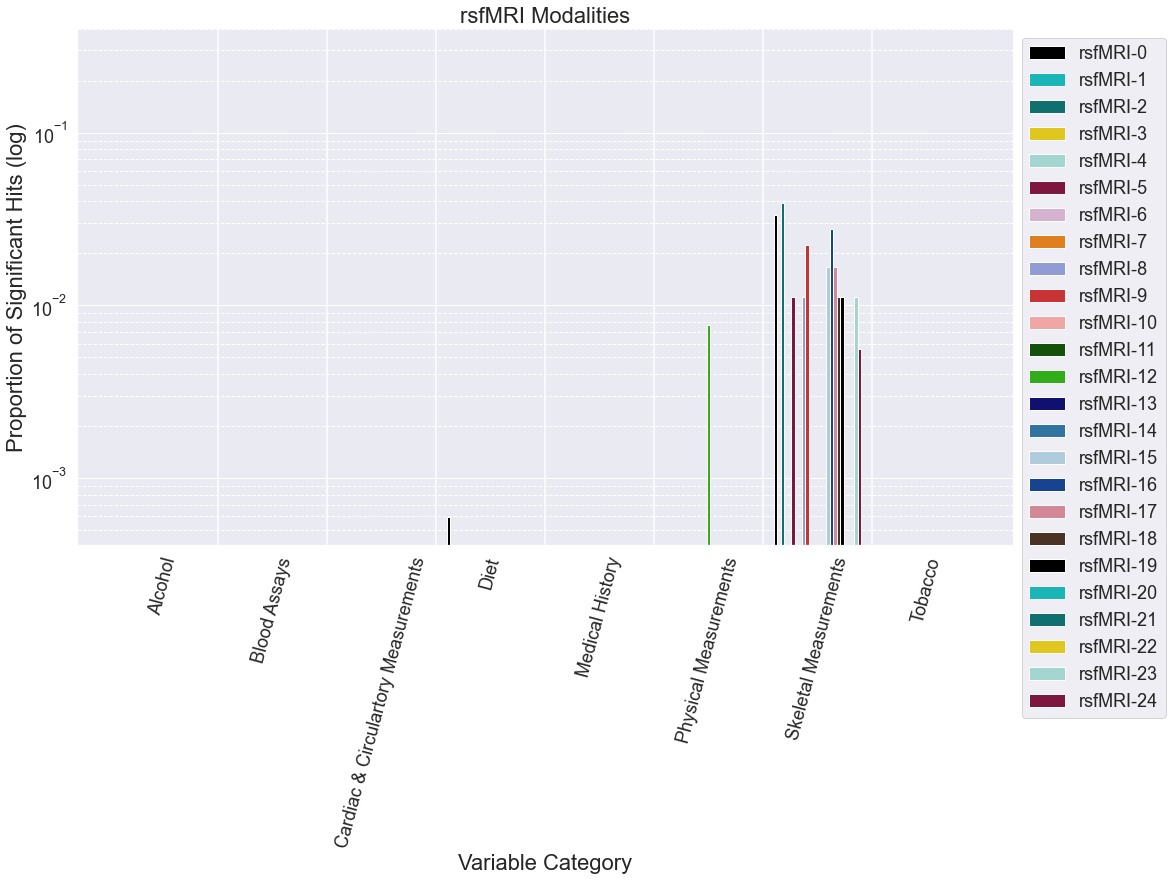

<Figure size 1152x691.2 with 0 Axes>

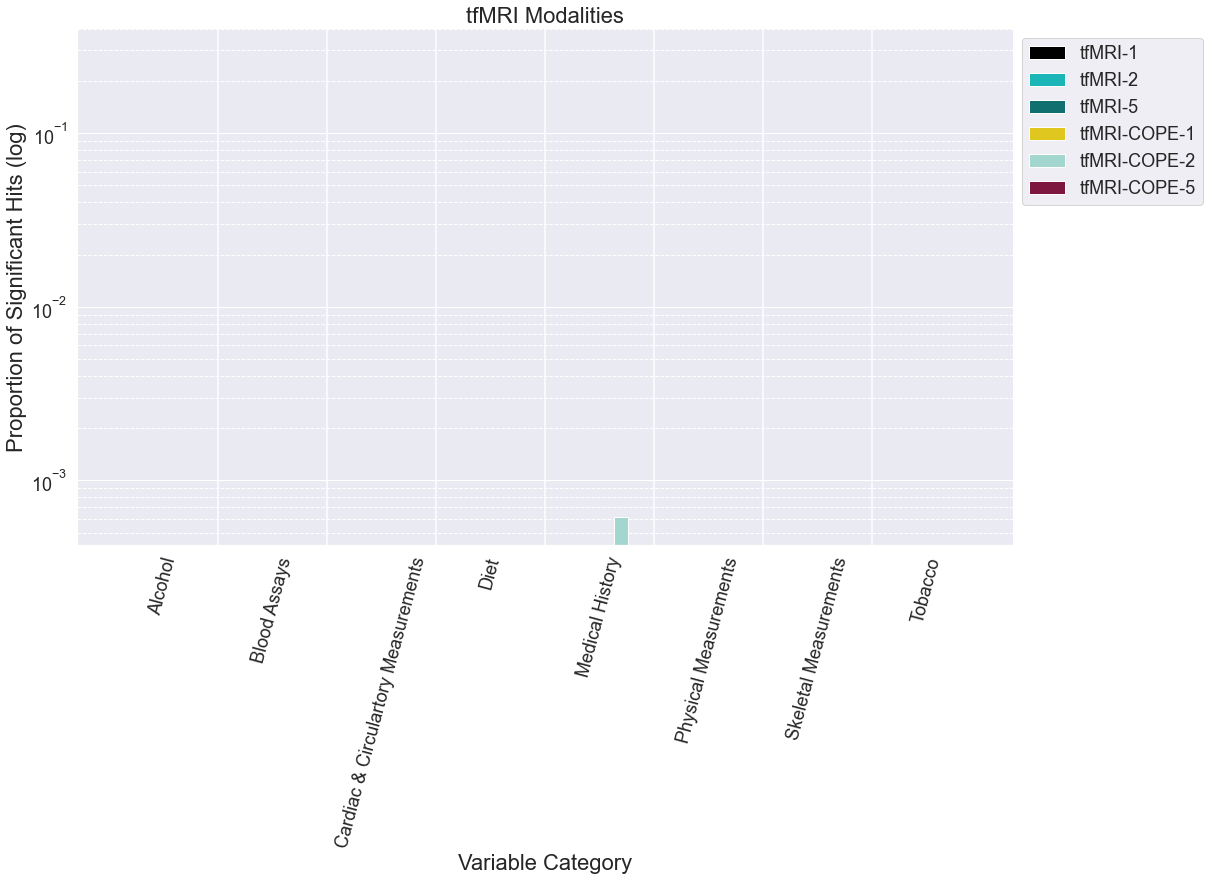

<Figure size 1152x691.2 with 0 Axes>

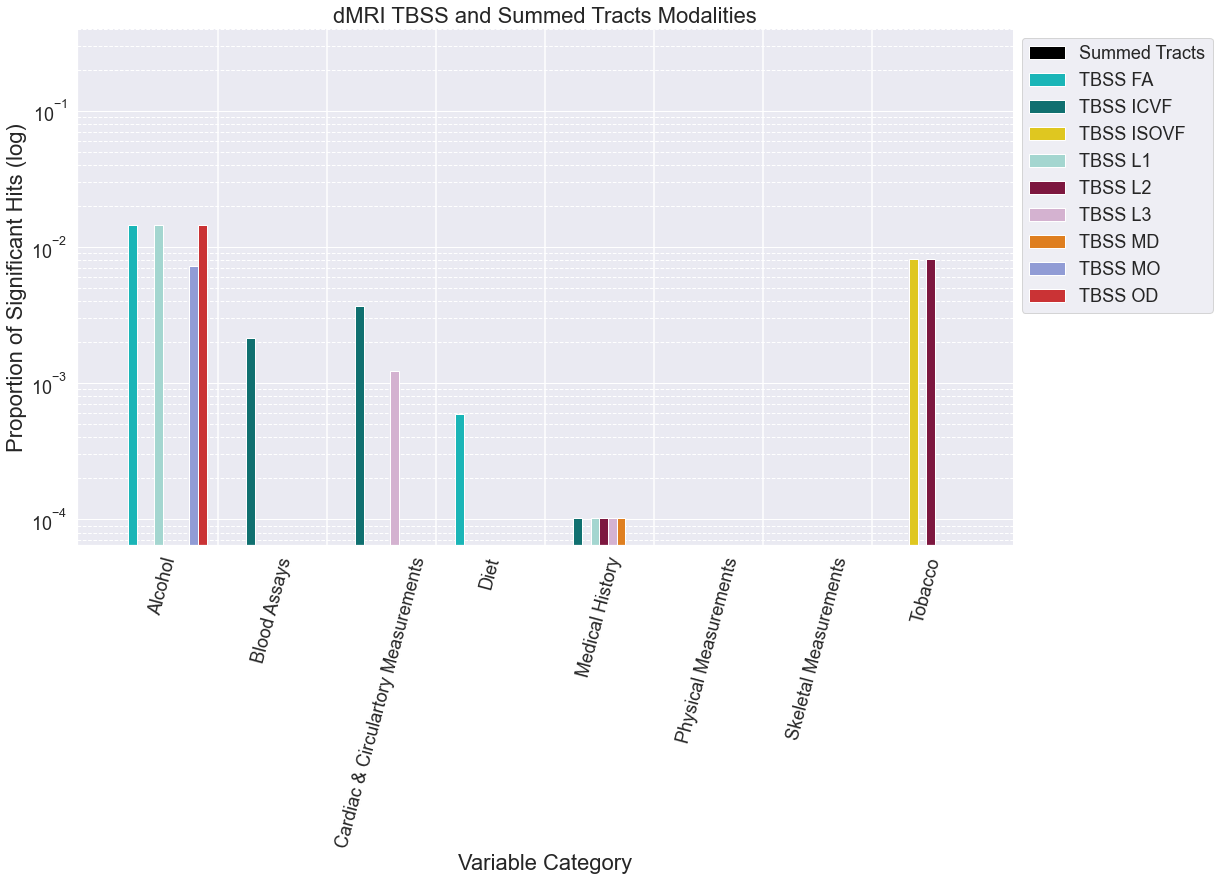

<Figure size 1152x691.2 with 0 Axes>

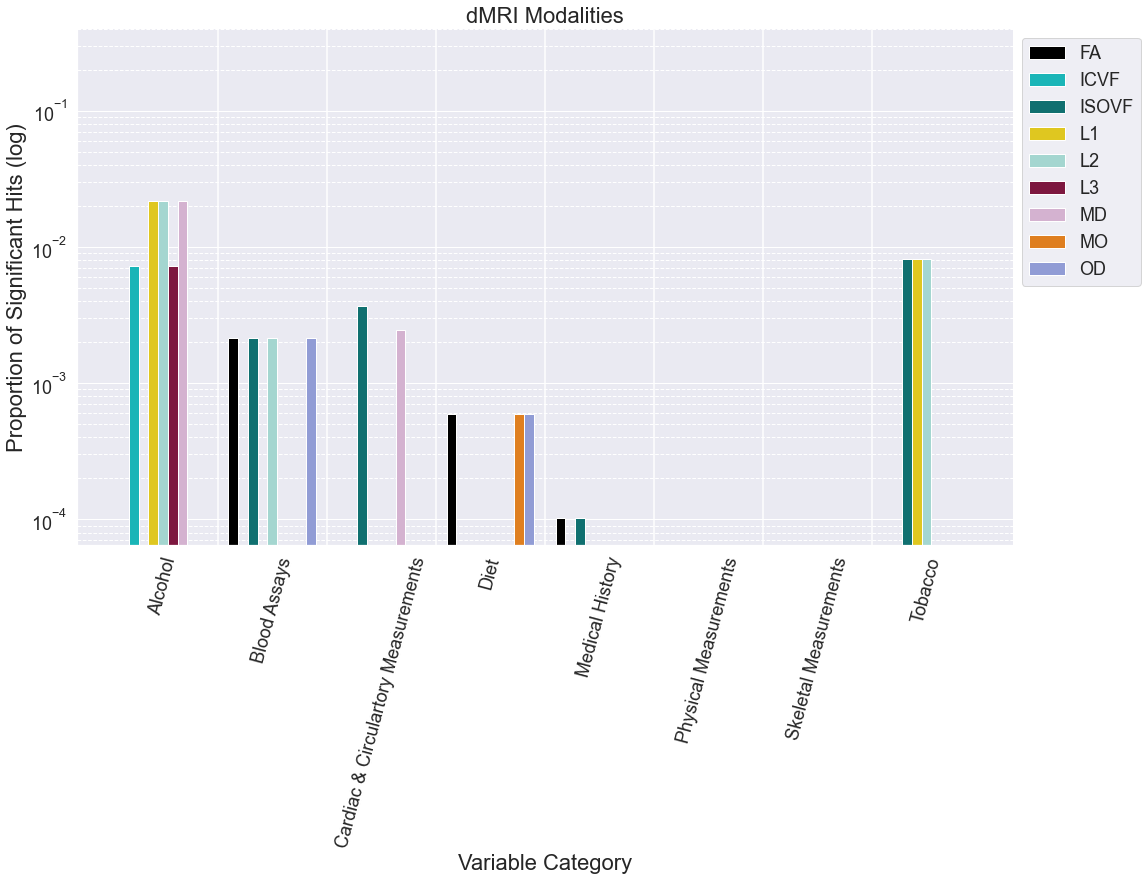

In [54]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'T1 Nonlinear') |
                           (df_dct.modality == 'T1 Linear') |
                           (df_dct.modality == 'Jacobian') |
                           (df_dct.modality == 'VBM') |
                           (df_dct.modality == 'T2 Nonlinear') |
                           (df_dct.modality == 'T2 Lessions') |
                           (df_dct.modality == 'SWI')
                          
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('sMRI and swMRI Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, ], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.4])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_FDR_proportion_significant_hits_sMRI and swMRI Modalities'+'.png', bbox_inches='tight', facecolor='white')


title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'rsfMRI-0') |
                           (df_dct.modality == 'rsfMRI-1') |
                           (df_dct.modality == 'rsfMRI-2') |
                           (df_dct.modality == 'rsfMRI-3') |
                           (df_dct.modality == 'rsfMRI-4') |
                           (df_dct.modality == 'rsfMRI-5') |
                           (df_dct.modality == 'rsfMRI-6') |
                           (df_dct.modality == 'rsfMRI-7') |
                           (df_dct.modality == 'rsfMRI-8') |
                           (df_dct.modality == 'rsfMRI-9') |
                           (df_dct.modality == 'rsfMRI-10') |
                           (df_dct.modality == 'rsfMRI-11') |
                           (df_dct.modality == 'rsfMRI-12') |
                           (df_dct.modality == 'rsfMRI-13') |
                           (df_dct.modality == 'rsfMRI-14') |
                           (df_dct.modality == 'rsfMRI-15') |
                           (df_dct.modality == 'rsfMRI-16') |
                           (df_dct.modality == 'rsfMRI-17') |
                           (df_dct.modality == 'rsfMRI-18') |
                           (df_dct.modality == 'rsfMRI-19') |
                           (df_dct.modality == 'rsfMRI-20') |
                           (df_dct.modality == 'rsfMRI-21') |
                           (df_dct.modality == 'rsfMRI-22') |
                           (df_dct.modality == 'rsfMRI-23') |
                           (df_dct.modality == 'rsfMRI-24')         
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('rsfMRI Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, ], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.4])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_FDR_proportion_significant_hits_rsfMRI Modalities'+'.png', bbox_inches='tight', facecolor='white')




title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'tfMRI-1') |
                           (df_dct.modality == 'tfMRI-2') |
                           (df_dct.modality == 'tfMRI-5') |
                           (df_dct.modality == 'tfMRI-COPE-1') |
                           (df_dct.modality == 'tfMRI-COPE-2') |
                           (df_dct.modality == 'tfMRI-COPE-5') 
                           
                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('tfMRI Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, ], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.4])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_FDR_proportion_significant_hits_tfMRI Modalities'+'.png', bbox_inches='tight', facecolor='white')




title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[(df_dct.modality == 'Summed Tracts') |
                           (df_dct.modality == 'TBSS FA') |
                           (df_dct.modality == 'TBSS ICVF') |
                           (df_dct.modality == 'TBSS ISOVF') |
                           (df_dct.modality == 'TBSS L1') |
                           (df_dct.modality == 'TBSS L2') |
                           (df_dct.modality == 'TBSS L3') | 
                           (df_dct.modality == 'TBSS MD') |
                           (df_dct.modality == 'TBSS MO') |
                           (df_dct.modality == 'TBSS OD') 

                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('dMRI TBSS and Summed Tracts Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, ], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.4])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_FDR_proportion_significant_hits_dMRI TBSS and Summed Tracts Modalities'+'.png', bbox_inches='tight', facecolor='white')




title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct[
                           (df_dct.modality == 'FA') |
                           (df_dct.modality == 'ICVF') |
                           (df_dct.modality == 'ISOVF') |
                           (df_dct.modality == 'L1') |
                           (df_dct.modality == 'L2') |
                           (df_dct.modality == 'L3') | 
                           (df_dct.modality == 'MD') |
                           (df_dct.modality == 'MO') |
                           (df_dct.modality == 'OD') 

                          ],
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('dMRI Modalities', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, ], ymin=0, ymax=1, color='white')
plt.ylim([0, 0.4])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_FDR_proportion_significant_hits_dMRI Modalities'+'.png', bbox_inches='tight', facecolor='white')